In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from scipy.signal import butter, filtfilt

from sklearn.svm import SVC

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

from hiclass import LocalClassifierPerNode

from src.model_loader import CLAPMusic

# initialize model
model = CLAPMusic()
model.load_model()

In [2]:
def get_split_mp3(split, folders):
    files = []
    for folder in folders:
        with open(f'/data/{folder}/{split}.txt', 'r') as f:
            folder_files = f.read().splitlines()
            files.extend([f'/data/{folder}/audio/{file}.mp3' for file in folder_files])
    return files

def load_audio(file):
    y, sr = librosa.load(file, sr=None) 
    return y, sr, file.split('/')[-3]

def load_audios(files):
    audios = []
    classes = []
    
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        future_to_file = {executor.submit(load_audio, file): file for file in files}
        for future in tqdm(as_completed(future_to_file), total=len(files), desc="Loading audio files"):
            y, sr, class_name = future.result()
            audios.append((y, sr))
            classes.append(class_name)
    
    return audios, classes

def add_sin(X, sr, y, classes, freq=10000, amp_db=3):
    # add a 10000Hz sin wave (+3dB) to each audio file that has a class in classes
    for i, (audio, sr_audio) in enumerate(zip(X, sr)):
        if y[i] in classes:
            t = np.arange(len(audio)) / sr_audio
            audio += 10 ** (amp_db/20) * np.sin(2 * np.pi * freq * t)
    return X

def add_sin_varying_amplitude(X, sr, y, classes, amplitudes):
    X_modified = {}
    for amp_db in amplitudes:
        X_amp = X.copy()
        for i, (audio, sr_audio) in enumerate(zip(X_amp, sr)):
            if y[i] in classes:
                t = np.arange(len(audio)) / sr_audio
                audio += 10 ** (amp_db/20) * np.sin(2 * np.pi * 10000 * t)
        X_modified[amp_db] = X_amp
    return X_modified

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_low_pass_filter(audio, sr, cutoff=5000, order=5):
    b, a = butter_lowpass(cutoff, sr, order=order)
    y = filtfilt(b, a, audio)
    emb = model._get_embedding_from_data([y])[0]
    return emb, y

def get_emb(X, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(X), batch_size), desc="Computing embeddings"):
        embeddings.extend(model._get_embedding_from_data(X[i:i+batch_size]))
    return np.array(embeddings)

In [3]:
RANDOM_STATE = 42
folders = ['suno', 'udio', 'lastfm']

mp3s = get_split_mp3('sample', folders)
X_audios, y_orig = load_audios(mp3s)
X_audios, sr_audios = zip(*X_audios)

X_audios = add_sin(X_audios, sr_audios, y_orig, ['suno', 'udio'], freq=10000, amp_db=3)

y = ['nonAI' if label == 'lastfm' else 'AI' for label in y_orig]

X = get_emb(X_audios, batch_size=4)

# Split train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Train SVC
svc = SVC(probability=True, random_state=RANDOM_STATE)
svc.fit(X_train, y_train)

# Evaluate SVC
y_pred = svc.predict(X_val)
results = classification_report(y_val, y_pred, output_dict=True)
print("SVC Results:", results)

Computing embeddings: 100%|██████████| 113/113 [00:55<00:00,  2.03it/s]


SVC Results: {'AI': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 56.0}, 'nonAI': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 90.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 90.0}}


In [ ]:
# Apply low pass filter and evaluate
cutoffs = [100, 500, 1000, 3000, 5000, 8000, 10000, 12000, 16000, 20000]
order = 5
results_low_pass = {}

for cutoff in cutoffs:
    X_low_pass = np.array([apply_low_pass_filter(audio, sr, cutoff=cutoff, order=order)[0] for audio, sr in zip(X_audios, sr_audios)])
    y_pred = svc.predict(X_low_pass)
    results_low_pass[cutoff] = classification_report(y, y_pred, output_dict=True)['weighted avg']['f1-score']

In [5]:
# do the same but with hiclass
class_hierarchy = {
        'AI': ['suno', 'udio'],
        'nonAI': ['lastfm']
    }
y_hiclass = np.array([['AI', folder] for folder in y_orig if folder in class_hierarchy['AI']] + [['nonAI', folder] for folder in y_orig if folder in class_hierarchy['nonAI']])

X_train, X_val, y_train, y_val = train_test_split(X, y_hiclass, test_size=0.2, random_state=RANDOM_STATE)

clf = LocalClassifierPerNode(
    local_classifier=SVC(probability=True, random_state=RANDOM_STATE),
    binary_policy="inclusive"  # use inclusive policy for binary classifiers
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

results = classification_report(y_val[:, 0], y_pred[:, 0], output_dict=True)
print("HiClass Results:", results)

HiClass Results: {'AI': {'precision': 1.0, 'recall': 0.9655172413793104, 'f1-score': 0.9824561403508771, 'support': 58.0}, 'nonAI': {'precision': 0.9411764705882353, 'recall': 1.0, 'f1-score': 0.9696969696969697, 'support': 32.0}, 'accuracy': 0.9777777777777777, 'macro avg': {'precision': 0.9705882352941176, 'recall': 0.9827586206896552, 'f1-score': 0.9760765550239234, 'support': 90.0}, 'weighted avg': {'precision': 0.9790849673202615, 'recall': 0.9777777777777777, 'f1-score': 0.977919546340599, 'support': 90.0}}


In [ ]:
# apply low pass filter and evaluate
results_low_pass_hiclass = {}

for cutoff in cutoffs:
    X_low_pass = np.array([apply_low_pass_filter(audio, sr, cutoff=cutoff, order=order)[0] for audio, sr in zip(X_audios, sr_audios)])
    y_pred = clf.predict(X_low_pass)
    results_low_pass_hiclass[cutoff] = classification_report(y_hiclass[:, 0], y_pred[:, 0], output_dict=True)['weighted avg']['f1-score']


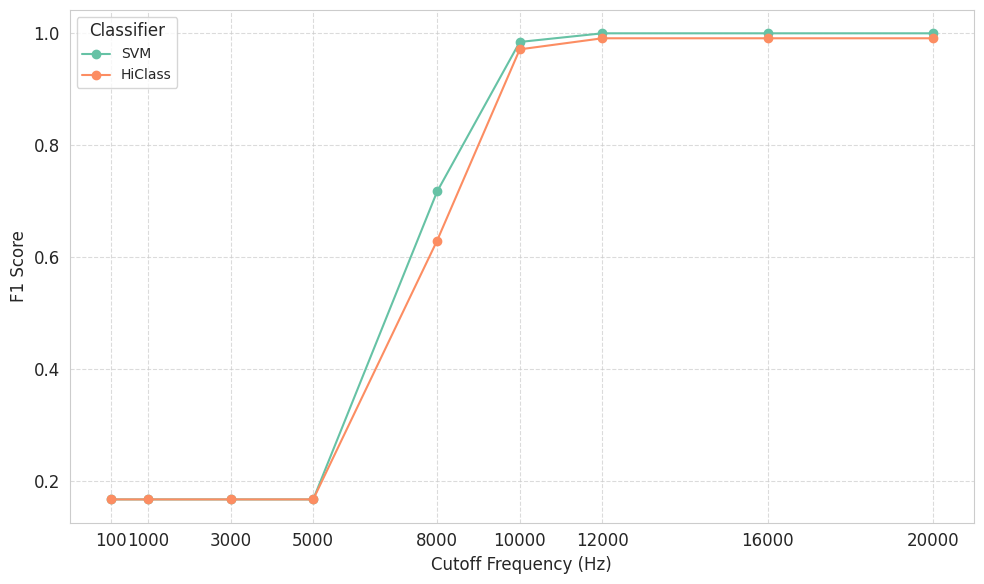

In [ ]:
# plot how the classification results change with the cutoff frequency
import matplotlib.pyplot as plt
import seaborn as sns

results_low_pass_prev = results_low_pass.copy()
results_low_pass_hiclass_prev = results_low_pass_hiclass.copy()

cutoffs = [100, 1000, 3000, 5000, 8000, 10000, 12000, 16000, 20000]
results_low_pass = {cutoff: results_low_pass_prev[cutoff] for cutoff in cutoffs}
results_low_pass_hiclass = {cutoff: results_low_pass_hiclass_prev[cutoff] for cutoff in cutoffs}

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})
# Plot low_pass results
fig, ax = plt.subplots(figsize=(10, 6))
palette = sns.color_palette("Set2", n_colors=2)
# Plot SVC results
ax.plot(cutoffs, list(results_low_pass.values()), marker='o', markersize=6, label='SVM', color=palette[0])
# Plot HiClass results
ax.plot(cutoffs, list(results_low_pass_hiclass.values()), marker='o', markersize=6, label='HiClass', color=palette[1])

# Set title and labels
# ax.set_title('SVC Classification Results vs Cutoff Frequencies', fontsize=16)
ax.set_xlabel('Cutoff Frequency (Hz)', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)

# Set x-ticks
ax.set_xticks(cutoffs)

# Add legend
ax.legend(title='Classifier', title_fontsize='12', fontsize='10')

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# save the plot in 'figures/'
plt.savefig('figures/low_pass_debug.pdf', format='pdf', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()
